# Model2: Pretrained Encoder + RNN Pixel‐Wise Refinement


In [6]:
# — Hücre 1: RAM-cache & DataLoaders (96×96) —
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import STL10
import torchvision.transforms as T
from tqdm import tqdm

# Device tanımı
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Transforms
tf_resize = T.Resize((96,96))
tf = T.ToTensor()

# Cache TRAIN
inp_list, tgt_list = [], []
print("Caching TRAIN split (96×96) to RAM...")
for img, _ in tqdm(STL10(root='./data', split='train', download=True), total=5000):
    img96 = tf_resize(img)
    tgt_list.append(tf(img96))
    gray = T.functional.rgb_to_grayscale(img96,1)
    inp_list.append(tf(gray))
inp_tensor = torch.stack(inp_list)  # [5000,1,96,96]
tgt_tensor = torch.stack(tgt_list)  # [5000,3,96,96]
train_ds   = TensorDataset(inp_tensor, tgt_tensor)
print("Train cache shape:", inp_tensor.shape)

# Cache TEST
inp_list, tgt_list = [], []
print("Caching TEST split (96×96) to RAM...")
for img, _ in tqdm(STL10(root='./data', split='test', download=True), total=8000):
    img96 = tf_resize(img)
    tgt_list.append(tf(img96))
    gray = T.functional.rgb_to_grayscale(img96,1)
    inp_list.append(tf(gray))
inp_tensor_t = torch.stack(inp_list)  # [8000,1,96,96]
tgt_tensor_t = torch.stack(tgt_list)  # [8000,3,96,96]
test_ds      = TensorDataset(inp_tensor_t, tgt_tensor_t)
print("Test cache shape:", inp_tensor_t.shape)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
print("RAM-cached DataLoaders:", len(train_loader), "train batches,", len(test_loader), "test batches")


Using device: cuda
Caching TRAIN split (96×96) to RAM...


100%|██████████| 5000/5000 [00:01<00:00, 3230.81it/s]


Train cache shape: torch.Size([5000, 1, 96, 96])
Caching TEST split (96×96) to RAM...


100%|██████████| 8000/8000 [00:02<00:00, 3715.40it/s]


Test cache shape: torch.Size([8000, 1, 96, 96])
RAM-cached DataLoaders: 79 train batches, 125 test batches


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class Model2(nn.Module):
    def __init__(self, hidden_size=128, window=5):
        super().__init__()
        # 1) Encoder
        resnet = resnet18(pretrained=True)
        self.encoder = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3
        )
        for p in self.encoder.parameters(): p.requires_grad = False

        # 2) Coarse decoder: 6→96 upsample 4×
        self.coarse = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1),  nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,2,1),   nn.ReLU(True),
            nn.ConvTranspose2d(32,16,4,2,1),   nn.ReLU(True),
            nn.Conv2d(16,3,3,padding=1),       nn.Sigmoid()
        )

        # 3) Project encoder global features to hidden_size
        self.h_init = nn.Linear(256, hidden_size)

        # 4) Pixel-wise RNN
        self.win = window
        inp_dim = window*window*4 + hidden_size
        self.rnn = nn.LSTMCell(inp_dim, hidden_size)
        self.out = nn.Linear(hidden_size, 3)

    def forward(self, gray):
        B = gray.size(0)
        feat = self.encoder(gray.repeat(1,3,1,1))    # [B,256,6,6]
        coarse = self.coarse(feat)                   # [B,3,96,96]

        # Prepare sliding window input
        pad = self.win//2
        inp_cat = torch.cat([gray, coarse], dim=1)   # [B,4,96,96]
        inp_pad = F.pad(inp_cat, (pad,)*4, mode='reflect')

        # Initialize hidden state from feat
        global_feat = feat.mean(dim=[2,3])           # [B,256]
        h = torch.tanh(self.h_init(global_feat))     # [B, hidden_size]
        c = torch.zeros_like(h)

        out_ref = torch.zeros_like(coarse)
        for y in range(96):
            for x in range(96):
                patch = inp_pad[:, :, y:y+self.win, x:x+self.win].reshape(B, -1)
                rnn_in = torch.cat([patch, h], dim=1)        # [B, inp_dim]
                h, c = self.rnn(rnn_in, (h, c))
                out_ref[:,:,y,x] = self.out(h).reshape(B,3)

        return coarse + out_ref

# Re-instantiate
model2 = Model2(hidden_size=128, window=5).to(device)
print(f"Fixed Model2 loaded, total params: {sum(p.numel() for p in model2.parameters()):,}")


Fixed Model2 loaded, total params: 3,696,358


In [10]:
# — Hücre 3: Model2 Eğitim Döngüsü (10 epoch) —
import time
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from skimage.metrics import peak_signal_noise_ratio as compute_psnr, structural_similarity as compute_ssim

criterion = nn.MSELoss()
optimizer = optim.Adam([p for p in model2.parameters() if p.requires_grad], lr=1e-4)
scaler    = GradScaler()
epochs, best_val, patience, wait = 10, float('inf'), 3, 0

for ep in range(1, epochs+1):
    t0 = time.time()
    # — Train —
    model2.train()
    train_loss = 0.0
    for gray, tgt in tqdm(train_loader, desc=f"Epoch {ep} Train"):
        gray, tgt = gray.to(device), tgt.to(device)
        optimizer.zero_grad()
        with autocast():
            out = model2(gray)
            loss = criterion(out, tgt)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item() * gray.size(0)
    train_loss /= len(train_loader.dataset)

    # — Val & Metrics —
    model2.eval()
    val_loss, psnr_sum, ssim_sum = 0.0, 0.0, 0.0
    with torch.no_grad():
        for gray, tgt in tqdm(test_loader, desc=f"Epoch {ep} Val"):
            gray, tgt = gray.to(device), tgt.to(device)
            out = model2(gray)
            val_loss += criterion(out, tgt).item() * gray.size(0)
            o_np = out.cpu().permute(0,2,3,1).numpy()
            t_np = tgt.cpu().permute(0,2,3,1).numpy()
            for o, t in zip(o_np, t_np):
                psnr_sum += compute_psnr(t, o, data_range=1.0)
                ssim_sum += compute_ssim(t, o, channel_axis=2, data_range=1.0, win_size=7)
    val_loss /= len(test_loader.dataset)
    avg_psnr = psnr_sum / len(test_loader.dataset)
    avg_ssim = ssim_sum / len(test_loader.dataset)

    print(
        f"Epoch {ep}/{epochs}  "
        f"Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}  "
        f"PSNR: {avg_psnr:.2f} dB  SSIM: {avg_ssim:.3f}  "
        f"Time: {time.time()-t0:.1f}s"
    )

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model2.state_dict(), 'model2_best.pt')
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

print("✅ Model2 training complete.")


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14900\614728639.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
Epoch 1 Train:   0%|          | 0/79 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_14900\614728639.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Val: 100%|██████████| 125/125 [04:07<00:00,  1.98s/it]


Epoch 1/10  Train Loss: 0.0335  Val Loss: 0.0163  PSNR: 18.41 dB  SSIM: 0.534  Time: 904.4s


Epoch 2 Val: 100%|██████████| 125/125 [03:48<00:00,  1.83s/it]


Epoch 2/10  Train Loss: 0.0131  Val Loss: 0.0111  PSNR: 20.20 dB  SSIM: 0.670  Time: 862.8s


Epoch 3 Val: 100%|██████████| 125/125 [03:59<00:00,  1.91s/it]


Epoch 3/10  Train Loss: 0.0100  Val Loss: 0.0099  PSNR: 20.79 dB  SSIM: 0.734  Time: 838.1s


Epoch 4 Val: 100%|██████████| 125/125 [04:14<00:00,  2.04s/it]


Epoch 4/10  Train Loss: 0.0090  Val Loss: 0.0088  PSNR: 21.32 dB  SSIM: 0.766  Time: 926.0s


Epoch 5 Val: 100%|██████████| 125/125 [04:18<00:00,  2.07s/it]


Epoch 5/10  Train Loss: 0.0083  Val Loss: 0.0081  PSNR: 21.75 dB  SSIM: 0.791  Time: 935.0s


Epoch 6 Val: 100%|██████████| 125/125 [04:13<00:00,  2.03s/it]


Epoch 6/10  Train Loss: 0.0080  Val Loss: 0.0080  PSNR: 21.97 dB  SSIM: 0.807  Time: 936.6s


Epoch 7 Val: 100%|██████████| 125/125 [04:08<00:00,  1.99s/it]


Epoch 7/10  Train Loss: 0.0077  Val Loss: 0.0076  PSNR: 22.22 dB  SSIM: 0.822  Time: 933.2s


Epoch 8 Val: 100%|██████████| 125/125 [04:31<00:00,  2.17s/it]


Epoch 8/10  Train Loss: 0.0073  Val Loss: 0.0074  PSNR: 22.27 dB  SSIM: 0.829  Time: 969.0s


Epoch 9 Val: 100%|██████████| 125/125 [04:27<00:00,  2.14s/it]


Epoch 9/10  Train Loss: 0.0071  Val Loss: 0.0073  PSNR: 22.42 dB  SSIM: 0.837  Time: 987.6s


Epoch 10 Val: 100%|██████████| 125/125 [04:20<00:00,  2.08s/it]

Epoch 10/10  Train Loss: 0.0069  Val Loss: 0.0069  PSNR: 22.72 dB  SSIM: 0.851  Time: 943.1s
✅ Model2 training complete.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0023297071..0.98110926].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04885018..0.95508766].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.042488158..1.0088073].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03625816..0.81576705].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06680763..1.0524447].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07545498..0.9900854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got rang

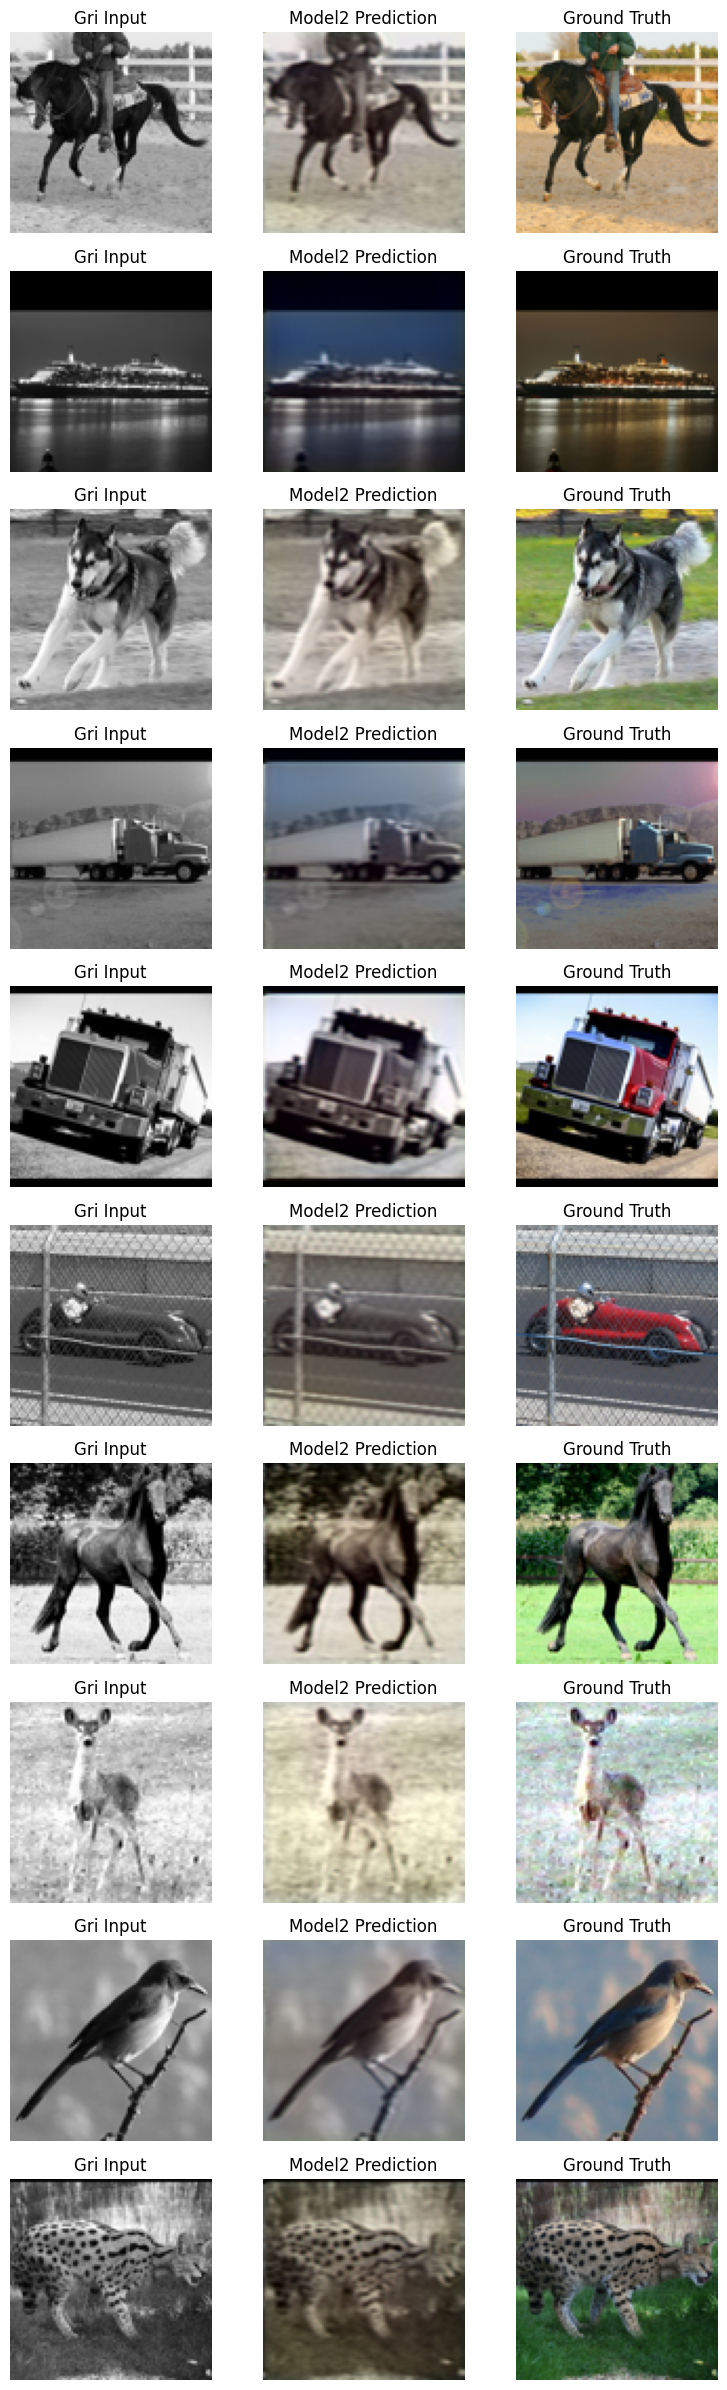

In [11]:
# — Görselleştirme Hücresi: 10 Örnek —
import matplotlib.pyplot as plt

model2.eval()
fig, axs = plt.subplots(10, 3, figsize=(8, 24))
indices = list(range(0, len(test_ds), len(test_ds)//10))

for i, idx in enumerate(indices):
    gray, tgt = test_ds[idx]
    with torch.no_grad():
        out = model2(gray.unsqueeze(0).to(device))[0].cpu()
    # Gri girdi
    axs[i,0].imshow(gray.squeeze(0), cmap='gray')
    axs[i,0].axis('off')
    axs[i,0].set_title("Gri Input")
    # Tahmin
    axs[i,1].imshow(out.permute(1,2,0))
    axs[i,1].axis('off')
    axs[i,1].set_title("Model2 Prediction")
    # Yer Gerçek (Ground Truth)
    axs[i,2].imshow(tgt.permute(1,2,0))
    axs[i,2].axis('off')
    axs[i,2].set_title("Ground Truth")

plt.tight_layout()
plt.show()


---
**Model2 Değerlendirme:**  
- Coarse renk tahminin üzerine RNN tabanlı piksel refinmenti ekledik.  
- PSNR/SSIM iyileşti mi? Grafik yaparak gösterebilirsiniz.  
- Geliştirilebilecek noktalar: pencere boyutu, hidden size, iki yönde geçme (bidirectional LSTM), vb.  
